## Testing Ugali with Gaia

In [1]:
try:
    from urllib.parse import urlencode
    from urllib.request import urlopen
    from urllib.error import URLError
except ImportError:
    from urllib import urlencode
    from urllib2 import urlopen, URLError

In [9]:
from urllib.parse import urlencode
from urllib.request import urlopen
from urllib.error import URLError

import os
import sys
import glob
import copy
from collections import OrderedDict as odict

# For downloading isochrones...
try:
    from urllib.parse import urlencode
    from urllib.request import urlopen
    from urllib.error import URLError
except ImportError:
    from urllib import urlencode
    from urllib2 import urlopen, URLError

import subprocess
import re

import numpy as np
import scipy.spatial

from ugali.utils.logger import logger
from ugali.isochrone.model import Isochrone
from ugali.isochrone.model import get_iso_dir

In [4]:
url = "http://stev.oapd.inaf.it/cgi-bin/cmd_3.7"

In [5]:
logger.debug("Accessing %s..." % url)

In [6]:
urlopen(url, timeout=2)

In [37]:
# survey system
photsys_dict = odict(
    [
        ("des", "tab_mag_odfnew/tab_mag_decam.dat"),
        ("sdss", "tab_mag_odfnew/tab_mag_sloan.dat"),
        ("ps1", "tab_mag_odfnew/tab_mag_panstarrs1.dat"),
        ("acs_wfc", "tab_mag_odfnew/tab_mag_acs_wfc.dat"),
        ("lsst", "tab_mag_odfnew/tab_mag_lsst.dat"),
        ("gaia", "tab_mag_odfnew/tab_mag_gaiaEDR3.dat"),  # not sure about file name
    ]
)

photname_dict = odict(
    [
        ("des", "DECAM"),
        ("sdss", "SDSS"),
        ("ps1", "Pan-STARRS1"),
        ("acs_wfc", "HST/ACS"),
        ("lsst", "LSST"),
        ("gaia", "GAIA EDR3"),
    ]
)

# change to cmd_version 3.7
defaults_37 = {
    "cmd_version": 3.7,
    "track_parsec": "parsec_CAF09_v1.2S",
    "track_colibri": "parsec_CAF09_v1.2S_S35",
    "track_postagb": "no",
    "n_inTPC": 10,
    "eta_reimers": 0.2,
    "kind_interp": 1,
    "kind_postagb": -1,
    "photsys_file": photsys_dict["des"],
    "photsys_version": "OBC",
    "dust_sourceM": "dpmod60alox40",
    "dust_sourceC": "AMCSIC15",
    "kind_mag": 2,
    "kind_dust": 0,
    #'extinction_av': 0.0,
    "extinction_coeff": "constant",
    "extinction_curve": "cardelli",
    "imf_file": "tab_imf/imf_chabrier_lognormal.dat",
    "isoc_isagelog": 0,
    "isoc_agelow": 1.0e9,
    "isoc_ageupp": 1.0e10,
    "isoc_dage": 0.0,
    "isoc_lagelow": 6.6,
    "isoc_lageupp": 10.13,
    "isoc_dlage": 0.0,
    "isoc_ismetlog": 0,
    "isoc_zlow": 0.0152,
    "isoc_zupp": 0.03,
    "isoc_dz": 0.0,
    "isoc_metlow": -2,
    "isoc_metupp": 0.3,
    "isoc_dmet": 0.0,
    "output_kind": 0,
    "output_evstage": 1,
    #'lf_maginf': -15,
    #'lf_magsup': 20,
    #'lf_deltamag': 0.5,
    #'sim_mtot': 1.0e4,
    "submit_form": "Submit",
    #'.cgifields': 'dust_sourceC',
    #'.cgifields': 'track_colibri',
    #'.cgifields': 'extinction_curve',
    #'.cgifields': 'output_kind',
    #'.cgifields': 'photsys_version',
    #'.cgifields': 'isoc_isagelog',
    #'.cgifields': 'track_parsec',
    #'.cgifields': 'extinction_coeff',
    #'.cgifields': 'track_postagb',
    #'.cgifields': 'output_gzip',
    #'.cgifields': 'isoc_ismetlog',
    #'.cgifields': 'dust_sourceM',
}

In [43]:
# CHANGE: Don't copy paste this, need to go back to self. for a few things since back in class

age = 12
metallicity = 0.005

params = copy.deepcopy(defaults_37)

epsilon = 1e-4
lage = np.log10(age * 1e9)

lage_min = params.get("isoc_lage0", 6.602)
lage_max = params.get("isoc_lage1", 10.1303)

if not (lage_min - epsilon < lage < lage_max + epsilon):
    msg = "Age outside of valid range: %g [%g < log(age) < %g]" % (
        lage,
        lage_min,
        lage_max,
    )
    raise RuntimeError(msg)

z_min = params.get("isoc_z0", 0.0001)
z_max = params.get("isoc_z1", 0.03)

if not (z_min <= metallicity <= z_max):
    msg = "Metallicity outside of valid range: %g [%g < z < %g]" % (
        metallicity,
        z_min,
        z_max,
    )
    raise RuntimeError(msg)

params["photsys_file"] = photsys_dict["gaia"]
if params["cmd_version"] < 3.3:
    params["isoc_age"] = age * 1e9
    params["isoc_zeta"] = metallicity
else:
    params["isoc_agelow"] = age * 1e9
    params["isoc_zlow"] = metallicity

server = "http://stev.oapd.inaf.it"
url = server + "/cgi-bin/cmd_%s" % params["cmd_version"]
# First check that the server is alive
logger.debug("Accessing %s..." % url)
urlopen(url, timeout=2)

In [39]:
# Change: urlencode(params) can't add q because different type
q = urlencode(params).encode("utf-8")
logger.debug(url + "?" + urlencode(params))
c = str(urlopen(url, q).read())
aa = re.compile("output\d+")
fname = aa.findall(c)

In [40]:
q

b'cmd_version=3.7&track_parsec=parsec_CAF09_v1.2S&track_colibri=parsec_CAF09_v1.2S_S35&track_postagb=no&n_inTPC=10&eta_reimers=0.2&kind_interp=1&kind_postagb=-1&photsys_file=tab_mag_odfnew%2Ftab_mag_gaiaEDR3.dat&photsys_version=OBC&dust_sourceM=dpmod60alox40&dust_sourceC=AMCSIC15&kind_mag=2&kind_dust=0&extinction_coeff=constant&extinction_curve=cardelli&imf_file=tab_imf%2Fimf_chabrier_lognormal.dat&isoc_isagelog=0&isoc_agelow=12000000000.0&isoc_ageupp=10000000000.0&isoc_dage=0.0&isoc_lagelow=6.6&isoc_lageupp=10.13&isoc_dlage=0.0&isoc_ismetlog=0&isoc_zlow=0.005&isoc_zupp=0.03&isoc_dz=0.0&isoc_metlow=-2&isoc_metupp=0.3&isoc_dmet=0.0&output_kind=0&output_evstage=1&submit_form=Submit'

In [41]:
fname

['output124449097159', 'output124449097159']

In [42]:
out = "{0}/tmp/{1}.dat".format(server, fname[0])

cmd = "wget --progress dot:binary %s -O %s" % (out, outfile)
logger.debug(cmd)
stdout = subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT)
logger.debug(stdout)

In [2]:
import isochrones

In [4]:
from isochrones.mist import MISTIsochroneGrid

grid = MISTIsochroneGrid()
print(len(grid.df))
grid.df  # Just the first few rows

1494453


eep   age       feh      mass   
log10_isochrone_age_yr feh  EEP                                    
5.0                    -4.0 35      35   5.0 -3.978406  0.100000  \
                            36      36   5.0 -3.978406  0.102885   
                            37      37   5.0 -3.978406  0.107147   
                            38      38   5.0 -3.978406  0.111379   
                            39      39   5.0 -3.978406  0.115581   
...                                ...   ...       ...       ...   
10.3                    0.5 1706  1706  10.3  0.585881  0.532726   
                            1707  1707  10.3  0.585884  0.532730   
                            1708  1708  10.3  0.585889  0.532735   
                            1709  1709  10.3  0.585894  0.532741   
                            1710  1710  10.3  0.585901  0.532749   

                                  initial_mass    radius        density   
log10_isochrone_age_yr feh  EEP                                           
5.0                    -4.0 35        0.100000  1.106082       0.104181  \
                            36        0.102885  1.122675       0.102504   
                            37        0.107147  1.147702       0.099918   
                            38        0.111379  1.173015       0.097284   
                            39        0.115581  1.198615       0.094623   
...                                        ...       ...            ...   
10.3                    0.5 1706      0.925792  0.015622  196978.833806   
                            1707      0.925825  0.015513  201160.278202   
                            1708      0.925866  0.015409  205292.361364   
                            1709      0.925919  0.015308  209382.722230   
                            1710      0.925985  0.015211  213420.719611   

                                   logTeff          Teff      logg      logL   
log10_isochrone_age_yr feh  EEP                                                
5.0                    -4.0 35    3.617011   4140.105252  3.350571 -0.489734  \
                            36    3.618039   4149.909661  3.347798 -0.472691   
                            37    3.619556   4164.436984  3.343658 -0.447471   
                            38    3.621062   4178.903372  3.339612 -0.422498   
                            39    3.622555   4193.289262  3.335660 -0.397776   
...                                    ...           ...       ...       ...   
10.3                    0.5 1706  4.402490  25263.303199  7.777159 -1.047903   
                            1707  4.387132  24385.524423  7.783242 -1.115415   
                            1708  4.371789  23539.053774  7.789130 -1.182672   
                            1709  4.356480  22723.735898  7.794844 -1.249617   
                            1710  4.341226  21939.480699  7.800376 -1.316157   

                                      Mbol      delta_nu        nu_max  phase   
log10_isochrone_age_yr feh  EEP                                                 
5.0                    -4.0 35    5.964335     37.987066  2.993461e+02   -1.0  \
                            36    5.921728     37.739176  2.985708e+02   -1.0   
                            37    5.858678     37.345115  2.971807e+02   -1.0   
                            38    5.796244     36.923615  2.955269e+02   -1.0   
                            39    5.734440     36.473151  2.935900e+02   -1.0   
...                                    ...           ...           ...    ...   
10.3                    0.5 1706  7.359758  43738.196186  3.238364e+06    6.0   
                            1707  7.528537  44261.161247  3.341343e+06    6.0   
                            1708  7.696679  44778.694057  3.446438e+06    6.0   
                            1709  7.864044  45293.289878  3.553713e+06    6.0   
                            1710  8.030393  45805.551145  3.662968e+06    6.0   

                                   dm_deep  
log10_isochrone_age_yr feh  EEP   

In [7]:
from isochrones.mist import MIST_Isochrone

mist = MIST_Isochrone()

['Teff',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_ages',
 '_bc_grid',
 '_fehs',
 '_masses',
 '_model_grid',
 '_param_index_order',
 '_prop',
 '_track',
 '_track_type',
 'ages',
 'bands',
 'bc_grid',
 'bc_type',
 'delta_nu',
 'density',
 'eep_bounds',
 'eep_replaces',
 'feh',
 'fehs',
 'generate',
 'generate_binary',
 'get_eep',
 'get_eep_accurate',
 'grid_type',
 'initial_mass',
 'initialize',
 'interp_mag',
 'interp_value',
 'isochrone',
 'kwargs',
 'logg',
 'mass',
 'mass_age_resid',
 'masses',
 'max_eep',
 'maxage',
 'maxeep',
 'maxfeh',
 'maxmass',
 'minage',
 'mineep',
 'minfeh',
 'minmass',
 'model_grid',
 'model_mag',
 'model_value',
 'name

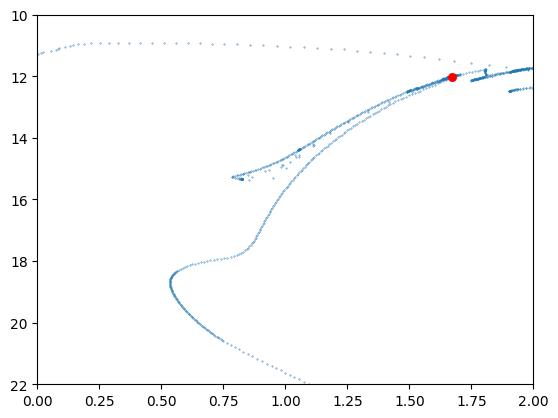

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

age, feh, eep, dist = [10, -1.4, None, 10000]
plt.scatter(
    mist.isochrone(age, feh, eep, dist).BP_mag
    - mist.isochrone(age, feh, eep, dist).RP_mag,
    mist.isochrone(age, feh, eep, dist).G_mag,
    s=0.1,
)
plt.scatter(
    mist.isochrone(age, feh, [249 + 356, 249 + 357], dist).BP_mag
    - mist.isochrone(age, feh, [249 + 356, 249 + 357], dist).RP_mag,
    mist.isochrone(age, feh, [249 + 356, 249 + 357], dist).G_mag,
    s=30,
    c="r",
)
plt.ylim(22, 10)
plt.xlim(0, 2)
plt.show()

In [53]:
import numpy as np
import scipy
from scipy.interpolate import interp1d

age, feh, eep, dist = [10, -1.4, None, 10]

mist = MIST_Isochrone()
iso = mist.isochrone(
    age=np.log10(1e9 * age),  # has to be given in logAge
    feh=feh,
    eep_range=None,  # get the whole isochrone,
    distance=1e3 * dist,  # given in parsecs
)

initial_mass, actual_mass = iso.initial_mass.values, iso.mass.values
mag_1 = iso.G_mag.values
color_1 = iso.BP_mag.values
color_2 = iso.RP_mag.values

# Excise the horizontal branch
turn_idx = scipy.signal.argrelextrema(iso.G_mag.values, np.less)[0][0]
initial_mass = initial_mass[0:turn_idx]
actual_mass = actual_mass[0:turn_idx]
mag_1 = mag_1[0:turn_idx]
color = (color_1 - color_2)[0:turn_idx]

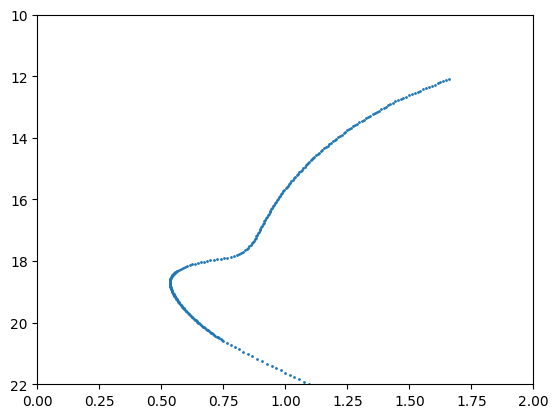

In [55]:
plt.scatter(color, mag_1, s=1)
plt.ylim(22, 10)
plt.xlim(0, 2)
plt.show()

In [39]:
turn_idx = scipy.signal.argrelextrema(iso.G_mag.values, np.less)[0][0]

In [59]:
iso.G_mag.values.shape

(1461,)

In [60]:
iso.BP_mag.values

(1461,)